# Quantum Zeno Effect in Quantum State Occupancy for a System Consisting of a Periodic Coulomb Potential

In this notebook, we aim to numerically solve the time dependent Schrodinger equation for a single particle in a periodic potential based on coulombs law. 
To do this, we use the split fourier transform method to numerically solve the Schrodinger equation, based on code by https://jakevdp.github.io/blog/2012/09/05/quantum-python/


The Schoringer equation in 1 dimension can be written as:

$$(1) i\hbar \frac{\partial\psi}{\partial t} = -\frac{\hbar}{2m} \frac{\partial^2}{\partial x^2} \psi + V \psi $$ 

To solve this, we use the Split-step fourier method

$$(2) \tilde{\psi}(k,t) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty}\psi(x,t)e^{-ikx} dx$$

We can write our normal wave function in terms of its inverse fourier transform:

$$(3) \psi(x,t) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty}\tilde{\psi}(k,t)e^{ikx}$$

We can then substitute (1) into (3)


$$(4) i\hbar \frac{\partial \tilde{\psi}}{\partial t} = \frac{\hbar^2}{2m}k^2 \tilde{\psi} + V\left(i\frac{\partial}{\partial k}\right)\tilde{\psi}$$

We see that in fourier space, the first part relating to the Hamiltonian is trivial to solve:

$$(5)    i\hbar \frac{\partial \tilde{\psi}}{\partial t} = \frac{\hbar^2}{2m}k^2 \tilde{\psi}$$

$$(6) \tilde{\psi}(u,t+\Delta t) = \tilde{\psi}(u,t)e^{-i\hbar k^2\Delta t /2m}$$

Similarly, our equation relating to the potential can be easily solved in the normal space

$$(7)i\hbar \frac{\partial\psi}{\partial t} = V(x) \psi$$
$$(8)\psi(x,t+\Delta t) = \psi(x,t) e^{-iV(x) \Delta t/\hbar}$$

These facts mean we can numerically solve our Schrodinger equation iteratively. Each iteration we do the following:

1) Compute a half step for x.
2) Calculate our $\tilde{\psi}$ by fourier transform.
3) Compute a full step in fourier space.
4) Calculate our $\psi$ by inverse fourier transform.
5) Compute a half step for x.

This method is similar to that of verlet integration, resulting in second order accuracy, and allowing for a stable result for our wave function.


## Implementation of the algorithm

In [73]:
using Plots; pyplot()
using FFTW
using NumericalIntegration
using LaTeXStrings


### Misc Utils

In [3]:
"""
Saves a plot to the desired directory and file path
"""
function saveFigToDir(dir, fname, fig)
    splitstr = split(dir, "/")

    for s in splitstr


        if(!isdir(s))
            mkdir(s)
        end
        cd(s)
    end
    savefig(fig, fname)
    for i in splitstr
        cd("..")
    end
end

saveFigToDir (generic function with 1 method)

### Potential

We wish to make a potential caused by a coulomb potential. The simplest way to do this, is to define a set of points that are our 'charges', and then calculate the sum of all charge contributions at each discrete point in our potential map. We also wish to have periodic boundary conditions for simplicity. 
This is implemented in the function below.


In [4]:
"""
Makes a potential based on a coulomb potential in 1d.
Each 'point' represents a charge. We have 'points' number of points,
each equally spaced.
For each grid point of our potential, we calculate the total potential at this
point based on the 
"""
function MakePotential(points, p_width, a, V0)
    N = points * p_width
    
    pot = fill(V0 * 1.0, N)
    
    pos = zeros(points)
    for i in 1:points
        pos[i] = (i - 0.5) * p_width
    
        for x in 1:N
            
            x_d = (x - pos[i])
            x_d -= N * round(x_d/N)
            
            pot[x] -= 1/(1/V0 + a * x_d * x_d)
        end
    end
        
    return pot    
end

MakePotential

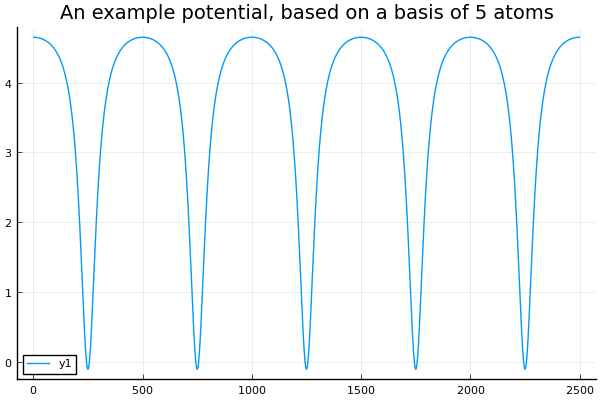

In [5]:
pot1 = MakePotential(5, 500, 0.0001, 5)
plot(pot1, title="An example potential, based on a basis of 5 atoms")

### Implementation of Split-Step Fourier Method

In [6]:
"""
A set of utilitary functions required for our calculations
"""

function arange_n(N)
        return Array(0:N-1)
end
function make_psi_x(psi_x, k, x, dx)
    return (psi_x .* exp.(-1im * k[1] .*x) * sqrt(2 * pi) / dx)
end
function get_psi_x(psi_mod_x, k, x, dx)
    return psi_mod_x .*exp.(1im * k[1] .*x)* sqrt(2 * pi) / dx
end
function make_psi_k(psi_k, x, dk, N)
    return psi_k .* exp.(1im * x[1] .*dk .* arange_n(N) )    
end
function get_psi_k(psi_mod_k, x, dk, N)
    return psi_mod_k .* exp.(-1im * x[1] .* dk * arange_n(N)) 
end
function compute_k_from_x(psi_mod_x)
    return fft(psi_mod_x)
end
function compute_x_from_k(psi_mod_k)
    return ifft(psi_mod_k)
end

"""
A struct that holds data required for our simulation.
Each time step accesses and modifies an instance of this struct
"""
mutable struct Simulation
    x; v_x;
    psi_x;

    hbar; m; t0; k;

    dx; dk; dt

    x_evolve_half; x_evolve; k_evolve

    psi_k; psi_mod_x; psi_mod_k

    function Simulation(x, psi_x0, V_x, dt=0.01, k0 = -28, hbar = 1., m = 1., t0 = 0.)

        N = size(x)[1]

        dx = x[2] - x[1];
        dk = 2 * pi / (N * dx);

        if(k0 == nothing)
            k0 = - 0.5 * N * dk
        end

        k =range(1, N, length=N).*dk .+ k0
        x_evolve_half = exp.(-0.5im .* V_x ./ hbar .* dt)
        x_evolve = x_evolve_half .* x_evolve_half
        k_evolve = exp.(-0.5im .* hbar ./ m .* (k.*k) .* dt)

        psi_mod_x = make_psi_x(psi_x0, k, x,dx)

        psi_k = compute_k_from_x(psi_mod_x)

        psi_mod_k = make_psi_k(psi_k, x, dk,N)

        new(x,V_x, psi_x0, hbar, m,t0, k, dx, dk, dt, x_evolve_half, x_evolve, k_evolve, psi_k, psi_mod_x, psi_mod_k)

    end
end
"""
Runs an iteration of our split-step fourier method to numerically
solve the Schrodinger equation
"""
function sim_iteration(sim::Simulation)
    

    sim.psi_mod_x .*= sim.x_evolve_half

    sim.psi_mod_k = compute_k_from_x(sim.psi_mod_x)
    sim.psi_mod_k .*= sim.k_evolve;  
    sim.psi_mod_x = compute_x_from_k(sim.psi_mod_k)

    sim.psi_mod_x .*= sim.x_evolve_half

    return sim.psi_mod_x
end




sim_iteration

In [7]:
"""
Integrates the array 'fx' with respect to 'x' until the
sum of the integral is greater that 'p'
"""
function integrate_till_p(x, fx, p)
    dx = x[2]-x[1]
    sum = 0
    for i in 1:size(fx)[1]
        #println("$p, $sum")
        sum += fx[i]*dx
        if(sum >= p)
            x_val = x[i]
            return x[i]
        end
    end
    return Inf
end
"""
Creates a gaussian wave packet with width 'w', with initial position 'x0' and
momentum 'k0'
"""
function gauss_x(x, w, x0, k0)
    
    exp_part = (-0.5 * (((x .- x0) /w) .* ((x .- x0) /w)) + 1im .*x .*k0)
    const_part = (w * sqrt(pi)) ^ (-0.5)
    
    return const_part * exp.(exp_part)
end
"""
Takes our wave function, turns it into a probability 
distrubition for our wave by P(x) = |Psi(x)|^2
before normalising it
"""
function to_real_normal(x, psi)
        real = abs.(psi .* conj(psi))
        normal = integrate(x, real)
        return real ./normal
end


to_real_normal

In [8]:
"""
Struct that contains data about our system. It contains the
atomic basis, as well as the total discrete system size. We also
calculate a Coulomb potential based on the supplied parameters.
"""
mutable struct System
    base; base_N; #base = number of atoms (# of peaks/troughs), base_N = # of points for each base
    N; x;
    Pot;
    dx; dt;
    t_steps;
    function System(base, base_N, a, V0, dt, t_steps)
        dx = 1/base_N
        N = base * base_N
        
        x = Array(1:N) * dx
        
        pot = MakePotential(base, base_N, a, V0)
        
        return new(base, base_N, N,x, pot, dx, dt, t_steps)
    end
    
end
"""
Simple struct that contains data about our initial wave function
"""
struct Wave
    x0
    vel0
    width
end

In [9]:
#Simple struct that hodls components required when making an animation
struct AnimationResult
    x; prob_x; v_x; t_steps;    
end
"""
Plots an animation result as a gif, and saves to the specified file.
tskip = number of result frames skipped for each animation frame.
If Autoscale is true, we scale our wave function and translate it, such that
the animation always shows the relative size of the probabiltiy distribution
of our wave function's position within our potential.
"""
function PlotAnimation(animResult::AnimationResult, file, tskip=10, autoscale=false)

    anim = Animation()
    
    T = size(animResult.prob_x)[1]
    
    minPot = min(animResult.v_x ...)
    maxPot = max(animResult.v_x ...)
    maxPsi = max(animResult.prob_x ...)
    
    
    psi_delta = 0.5 * (minPot + maxPot)
    
    
    p = plot(size=(600, 300))
    for t in 1:tskip:T
        
        if(t > T)
            break
        end
        
        #println(t)
        plot([animResult.x, animResult.x], [animResult.prob_x[t] .+ psi_delta, animResult.v_x])
        frame(anim)
        
    end
    
   
    gif(anim, file, fps=20)
        
end



PlotAnimation (generic function with 3 methods)

In [10]:
"""
Performs an integration over each of our possible quantum states,
returning the probability that our system is in each state. This allows us to
'measure' our quantum system without actually applying a measurement
"""
function calcStateProb(sys::System, prob_x, sim::Simulation)
    #array to hold results
    probs = zeros(sys.base)
    
    for g in 1:sys.base
        
        base_low_index = (g - 1) * sys.base_N + 1 
        base_upper_index = (g  ) * sys.base_N 
        
        P_base = integrate(sim.x[base_low_index:base_upper_index], prob_x[base_low_index:base_upper_index])
        probs[g] = P_base
    end
    return probs
end
"""
Takes a set of state probabilities as an array, of the form [t_steps, state_prob],
and selects only the state 'state', before plotting it.
"""
function plotSingleStateProb(state_p, label, state, title=nothing)
    N = size(state_p)[1]
    x = Array(1:N)/N
    
    plt = plot(x, state_p[:,state], label=label)
    if(title != nothing)
        plot!(title=title)
    end
    plot!(xlabel = "Time", ylabel="Probability of state occupancy")
    
    return plt
end
"""
Takes a set of state probabilities as an array, of the form [t_steps, state_prob],
and plots them all on one graph
"""
function plotStateProb(state_p, labels, title=nothing)
    N = size(state_p)[1]
    x = Array(1:N)/N
    plt = plot(x, state_p, label=labels)
    if(title != nothing)
        plot!(title=title)
    end
    plot!(xlabel = "Time", ylabel="Probability of state occupancy")
    
    return plt
end


plotStateProb (generic function with 2 methods)

In [11]:
"""
Measures our wave function. We stochastically decide the position of the wave
function based on its probability distribution. This position will fall within
one of the atomic basis zones (between two atoms). Our measurement is only accurate up
to the width of any one of these basis points. As a result, we scale our wave function such
that it has a probabilitiy of 0 in all other zones, before scaling our wave function within
its measured area to unity.
"""
function measure(sys::System, prob_x, sim::Simulation)
   
    p = rand()
    #Calculate the position of our wave function (stoachistcally)
    x0 = integrate_till_p(sim.x, prob_x, p)
    
    #println("x0 was $x0")
    
    #We iterate each base. Base[n] has range -> n-1 <= x0 < n for n =1,2,3..., base
    for g in 1:sys.base
        
        base_low_index = (g - 1) * sys.base_N + 1 
        base_upper_index = (g  ) * sys.base_N 
        
        #If our wave is wihin this basis point
        if(sys.x[base_low_index] <= x0 && x0 <= sys.x[base_upper_index])
            
            
            
            #We define this array which acts as a mask, 
            #A value of 0 is a point where we know the wave not to be
            #we multiply this with our psi, resulting in removal of probability of
            #wave existence outside of the region it has been measured in.
            mult_array = zeros(sys.N)
            mult_array[base_low_index:base_upper_index] .= 1            
            sim.psi_mod_x .*= mult_array 
            
            P_N = integrate(sim.x[base_low_index:base_upper_index], prob_x[base_low_index:base_upper_index])
            #Scale wave function to unity
            sim.psi_mod_x ./= P_N
            
            return g
            
           # smooth_phi(sim)
        end
    end
    println("an error?: $x0")
    
    return 1
end

measure

### Main Calculation Function

In [12]:
function RunSimulation(sys::System, wave::Wave, mf, iterations, state_measure=100, returnAnim=false, printProgress=false)
    
    total_measurements = mf < 0 ? 1 : Int(ceil(sys.t_steps/mf))
    
    if(mf < 0)
        mf = sys.t_steps + 1
    end
    animResult = Any[]
    
    #total_moved = 0
    
    #m_index = (sys.base_N, 2*sys.base_N)
    
    
    iteration_10_perc = ceil(iterations * 0.1)

    total_state_measure = Int(ceil(sys.t_steps/state_measure))
    
    state_prob = zeros(total_state_measure, sys.base)
    
    
    
    for it in 1:iterations
      
        psi_x0 = gauss_x(sys.x,wave.width, wave.x0, wave.vel0)

        sim = Simulation(sys.x, psi_x0, sys.Pot, sys.dt)
        
        if(it ==1 && returnAnim)
           push!(animResult, to_real_normal(sys.x, sim.psi_mod_x)) 
        end
        #part_moved = false
        prob_x = nothing
        #occupancy_data[1, 2] +=1
        #m_num = 2
        state_m_num = 1
        
        for t in 1:sys.t_steps
            #Iterate our wave and find probability density of wave now
            prob_x = to_real_normal(sys.x, sim_iteration(sim))
            
            #Store wave if we require an animation
            if(returnAnim && it==1)
               push!(animResult, prob_x) 
            end
            
            #If we wish to make a measurement this iteration,
            if(t % mf == 0)               
                #Then we make the measurement
                occ = measure(sys, prob_x, sim)                
                #m_num+=1
            end 
            #If we wish to store the current state occupancy probabilities
            if(t % state_measure == 0)
                state_prob[state_m_num, :] += calcStateProb(sys, prob_x, sim)
                state_m_num+=1
            end
            
        end
        
         if(it % iteration_10_perc == 0 && printProgress)
            perc = round(it/iterations * 100, digits=2)
            println("$perc% complete\r")
        end
        

    end
    
    state_prob ./= (iterations * 1.0)
    if(returnAnim)
        
        anim = AnimationResult(sys.x, animResult, sys.Pot, sys.t_steps)
        return state_prob, anim
    end
    return state_prob
    
end


RunSimulation (generic function with 4 methods)

## 2 Level system

In [47]:
sys = System(2, 300,  0.00001, 40, 0.001, 31000)
wave = Wave(1.5, 0, .15)
state_p, animResult = RunSimulation(sys, wave, -1, 1, 80, true, true);


100.0% complete


In [46]:
PlotAnimation(animResult, "level_2_mf_none.gif", 40, false)


LoadError: InterruptException:

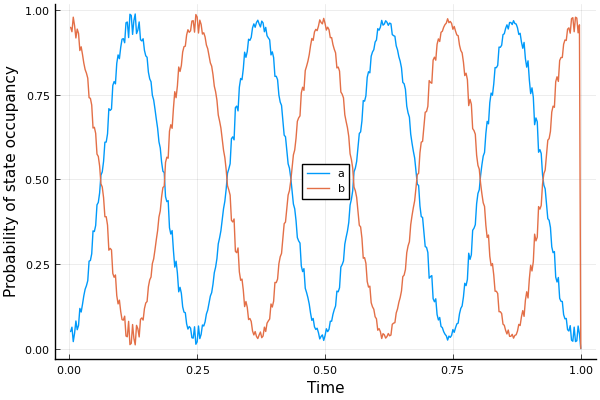

In [48]:
plotStateProb(state_p, ["a" "b"])


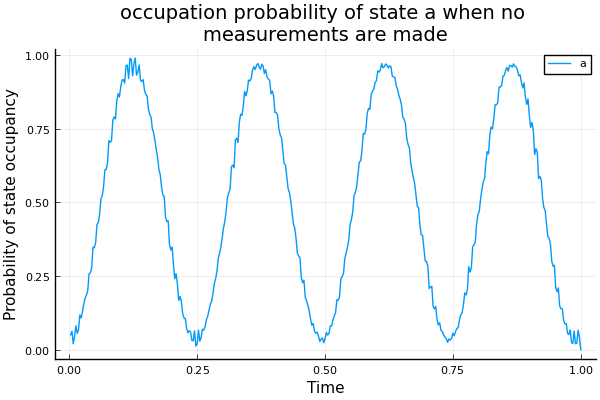

In [49]:
plotSingleStateProb(state_p, "a", 1, "occupation probability of state a when no \nmeasurements are made")

With the system in its current set up, when no measurements are applied we see an oscillation. If we look at the occupational probability of just our first state, *a*, we see this even more clearly. We can now see what effect applying regular measurements does to the occupation probability

In [32]:
struct StateOccResult
    state_p; x;
    function StateOccResult(state_p)
        N = size(state_p)[1]

        x = Array(1:N)/N
        return new(state_p, x)
    end
end

In [58]:
all_mf = [-1, 1150, 775, 400]
T_mf = size(all_mf)[1]

iterations = 1000

state_results = Array{StateOccResult}(undef, T_mf)
anim_results = Array{AnimationResult}(undef, T_mf)

for i in 1:T_mf
    
    mf = all_mf[i]
    iter = mf<0 ? 1 : iterations
    
    println("Starting simulation for mf: $mf")
    state_p, animRes = RunSimulation(sys, wave, mf, iter, 80, true, false);
    state_results[i] = StateOccResult(state_p)
    anim_results[i] = animRes
    println("Finished simulation for mf: $mf")
end

Starting simulation for mf: -1
Finished simulation for mf: -1
Starting simulation for mf: 1150
Finished simulation for mf: 1150
Starting simulation for mf: 775
Finished simulation for mf: 775
Starting simulation for mf: 400
Finished simulation for mf: 400


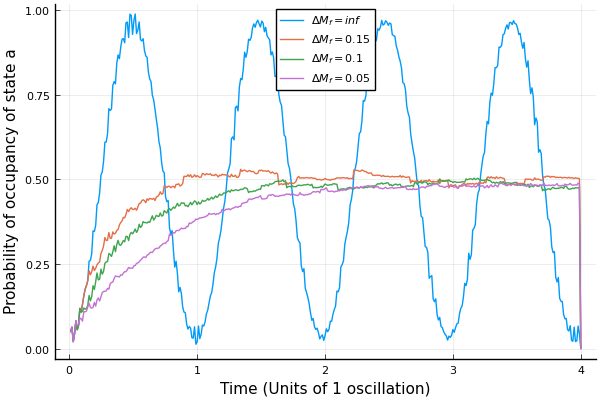

In [75]:
plt = plot(xlabel = "Time (Units of 1 oscillation)", ylabel="Probability of occupancy of state a")
for i in 1:T_mf
    mf = all_mf[i]
    
    lab = nothing
    
    if(mf < 0)
        lab=L"\Delta M_f = inf"
    else
        lab = L"\Delta M_f = " * string(round(4*(mf/sys.t_steps), digits=2))
    end
    
    
    
    
    plot!(state_results[i].x .* 4, state_results[i].state_p[:,1], label=lab)
    
end

plt

LoadError: UndefRefError: access to undefined reference

In [76]:
saveFigToDir("figs/two_level", "two_level_rabi_like.pdf", plt)